In [20]:
%qtconsole

In [124]:
import os
from os.path import expanduser
home = expanduser("~")
datap = os.path.join(home,'Documents','repos','kagle','yelp','Data')
import pandas as pd
import numpy as np

In [144]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Data exploration

## The competition 

**In this competition, we are given photos that belong to a business and asked to predict the business attributes**

## A look in the different files

The training data consist of
- a folder containing the images - Each image have an id
- a csv file linking each image to its bussiness id
- a csv file linking each bussiness id to the corresponding labels

In [117]:
train = pd.read_csv(os.path.join(datap,'train.csv'))
train_photo_to_biz_ids = pd.read_csv(os.path.join(datap,'train_photo_to_biz_ids.csv'))
train_photo_to_biz_ids.photo_id = map(str,train_photo_to_biz_ids.photo_id)

In [118]:
train.head(2)

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8


In [119]:
train_photo_to_biz_ids.head(2)

,photo_id,business_id
0,204149,3034
1,52779,2805


In the following, I gather everythin within the same pd dataframe for clarity

In [126]:
train_photos_names = os.listdir(os.path.join(datap,'train_photos'))
train_photos_paths = [os.path.join(datap,f) for f in train_photos_names]
train_photos_ids = [int(f.split('.')[0]) for f in train_photos_names]
train_photos = pd.DataFrame(
    np.array([train_photos_names,train_photos_paths,train_photos_ids]).T,
    columns =['photo_name','photo_path','photo_id'])
train_photos = pd.merge(train_photos,train_photo_to_biz_ids,on ='photo_id')
train_photos = pd.merge(train_photos,train, on = 'business_id')
train_photos.head()

,photo_name,photo_path,photo_id,business_id,labels
0,10.jpg,/Users/cthorey/Documents/repos/kagle/yelp/Data...,10,242,0 2 5 6 8
1,100823.jpg,/Users/cthorey/Documents/repos/kagle/yelp/Data...,100823,242,0 2 5 6 8
2,100842.jpg,/Users/cthorey/Documents/repos/kagle/yelp/Data...,100842,242,0 2 5 6 8
3,101037.jpg,/Users/cthorey/Documents/repos/kagle/yelp/Data...,101037,242,0 2 5 6 8
4,101959.jpg,/Users/cthorey/Documents/repos/kagle/yelp/Data...,101959,242,0 2 5 6 8


Let's look at the distribution of pictures by restaurant

In [140]:
count_photo_by_business = train_photos.groupby('business_id').photo_id.count()

Instead of looking at numbers, we might plot the distribution

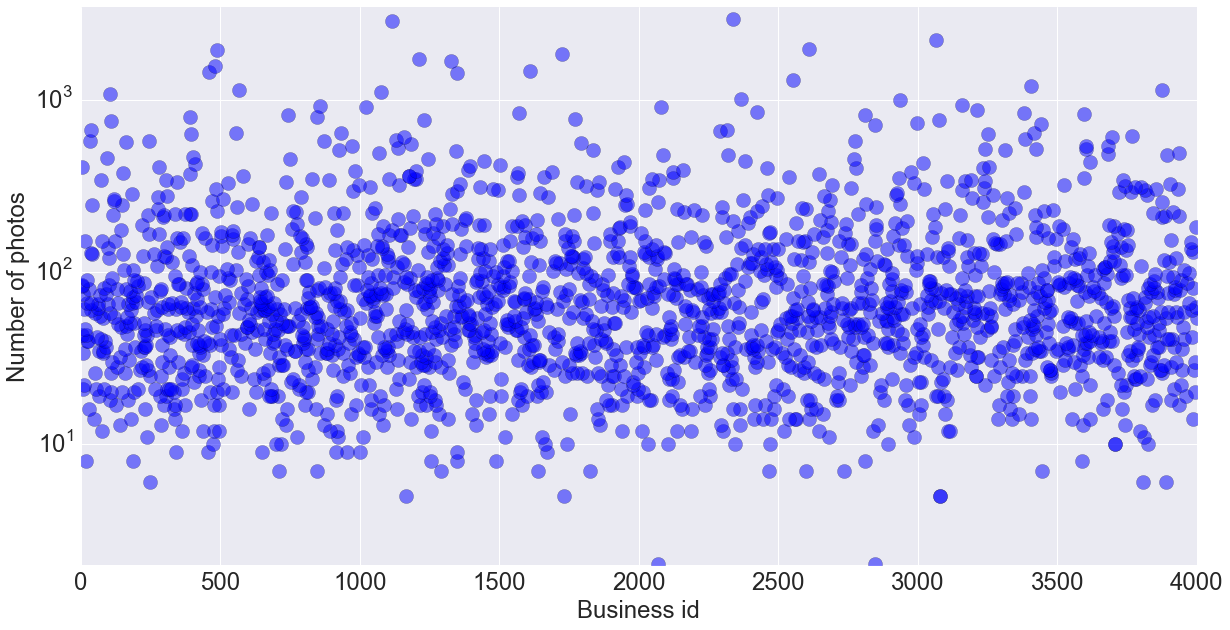

In [191]:
fig = plt.figure(figsize = (20,10))
ax = plt.subplot(111)
ax.scatter(count_photo_by_business.index,
            count_photo_by_business.values,
            marker = 'o',
            s= 200,
          alpha = 0.5)
ax.set_yscale('log')
ax.tick_params(labelsize = 24)
ax.set_xlim(0,max(count_photo_by_business.index))
ax.set_ylim(0,3500)
ax.set_ylabel('Number of photos',fontsize = 24)
ax.set_xlabel('Business id',fontsize = 24)

Therefore, the number of pictures by bussiness is preatty scattered. 

In [188]:
def return_pourcent_photo_below(x):
    y = np.sum(count_photo_by_business<x)/float(len(count_photo_by_business))
    print '%1.2f%% of the training example have less than %d photos'%(y*100,x)
    
return_pourcent_photo_below(10)
return_pourcent_photo_below(300)

1.65% of the training example have less than 10 photos
92.00% of the training example have less than 300 photos


Therefore, most of the business have between $20$ and $300$ photos. However, there are a few isntance with less than 10 pictures.

In [190]:
count_photo_by_business.sort_values().head(10)

business_id
2069    2
2846    2
1166    5
3080    5
3079    5
1733    5
3891    6
3809    6
247     6
848     7
Name: photo_id, dtype: int64

## Splitting the data in train/val/test 

Due to the diverse numbers of pictures for each bussiness, the usual approach is to perform a stratified split so that the training and validation label distribution were similar. To handle the whales with single photo, we can either a) put those images just in the training set (overestimating); or b) just in the validation set (underestimate). Note that putting the whales with 1 image into validation set would result in the classifier not be able to predict those whales at all!